In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import time
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader

In [2]:
moons, labels = make_moons(n_samples=65536, noise=0.1)

In [3]:
moons.shape

(65536, 2)

In [4]:
X = moons[:,0]
y = moons[:,1]

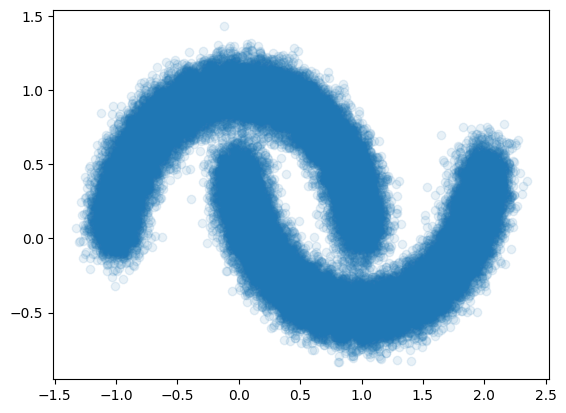

In [5]:
plt.scatter(X, y, alpha=0.1)

## Model

In [6]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

In [7]:
LR = 0.001
BATCH_SIZE = 4096
EPOCHS = 500
HIDDEN_DIM = 512

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
train_loader = DataLoader(torch.tensor(moons, dtype=torch.float32), batch_size=BATCH_SIZE, shuffle=True)

In [10]:
data = next(iter(train_loader))
data.shape

torch.Size([4096, 2])

In [11]:
vf = MLP(input_dim=2, time_dim=1, hidden_dim=HIDDEN_DIM).to(device) 

In [12]:
optimizer = torch.optim.Adam(vf.parameters(), lr=LR) 
criterion = nn.MSELoss()

## Training

In [13]:
from tqdm.auto import tqdm

for epoch in tqdm(range(EPOCHS)):
    for batch in train_loader:
        x1 = batch
        x1 = x1.to(device)
        x0 = torch.randn_like(x1)
        t = torch.rand(BATCH_SIZE, 1).to(device)
        xt = (1 - t) * x0 + t * x1
        
        ut = x1 - x0
        vt = vf(xt, t)

        loss = criterion(vt, ut)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
loss

tensor(0.9904, device='cuda:0', grad_fn=<MseLossBackward0>)

## Sampling

In [15]:
num_samples = 4096
steps = 200
dt = 1/steps

x0 = torch.randn(num_samples, 2, device=device)
ts = torch.arange(0, 1, dt, device=device)
xt = x0

with torch.no_grad():
    for _ in range(steps):
        xt = xt + vf(xt, t) * dt
x1 = xt

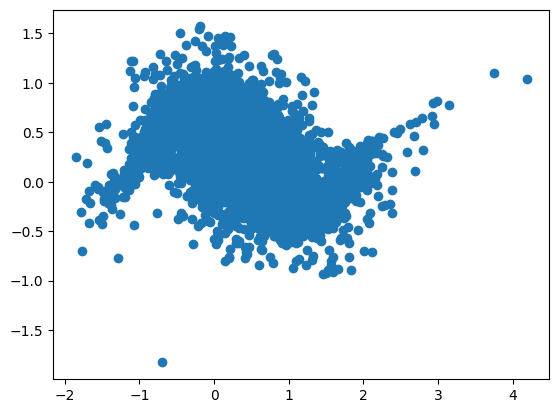

In [16]:
x1 = x1.to("cpu")
x = x1[:, 0]
y = x1[:, 1]
plt.scatter(x.detach().numpy(), y.detach().numpy())